## Calibration Plots CPL
Obtain calibration plots for the CPL. Just run all code to obtain the plots from the calibration section \
Author: Clara Hoffmann 

In [1]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import multiprocessing
from scipy import integrate
from tqdm import tqdm
from helpers import find_closest_element, Fy

In [2]:
# read in val data
true_y = np.load('../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/labels_val.npy')

density_path = '../../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [3]:
# estimate density 
kde = sm.nonparametric.KDEUnivariate(true_y)
kde.fit()
support = kde.support
endog = kde.endog
density_gauss = kde.density
no_points = 750
grid = np.linspace(min(density['axes']), max(density['axes']), no_points)

In [4]:
# read in cdf_i for validation observations
va_ridge_av_den = np.load('../../../../data/commaai/calibration/cpl_dens/va_ridge_av_dens.npy')
hmc_ridge_av_den = np.load('../../../../data/commaai/calibration/cpl_dens/hmc_ridge_av_dens.npy')
va_horse_av_den = np.load('../../../../data/commaai/calibration/cpl_dens/va_horse_av_dens.npy')
hmc_horse_av_den = np.load('../../../../data/commaai/calibration/cpl_dens/hmc_horse_av_dens.npy')

In [5]:
mc_preds = np.append(np.load('../../../../data/commaai/predictions/mc_dropout/mc_preds_2.npy'), 
                     np.load('../../../../data/commaai/predictions/mc_dropout/mc_preds_1.npy'), axis = 0)

In [6]:
mc_pred = mc_preds.reshape(mc_preds.shape[0]*mc_preds.shape[1])
kde = sm.nonparametric.KDEUnivariate(mc_pred)
kde.fit() # Estimate the densities
support_mc = kde.support
endog = kde.endog
density_mc = kde.density

In [7]:
density_ext_list_mdn = np.load('../../../../data/commaai/predictions/density_dropout_mdn.npy')
density_mdn = np.mean(density_ext_list_mdn, axis = 0)

## Marginal Calibration

<ipython-input-8-ce754a7b7ff4>:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout(rect=[0.05, 0, 1, 1])


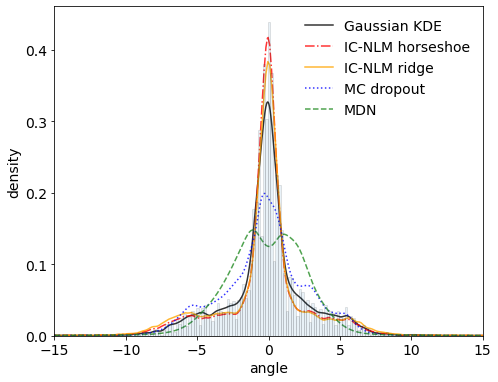

In [8]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
# Plot the histrogram
ax.plot(support, density_gauss, color = 'black', label = 'Gaussian KDE', alpha = 0.8)
ax.hist(true_y, bins=500, density=True,
        zorder=5, edgecolor='k', alpha=0.1)
ax.plot(grid, va_horse_av_den, color = 'red', linestyle= '-.', label = 'IC-NLM horseshoe', alpha = 0.8
       )
ax.plot(grid, va_ridge_av_den, color = 'orange', label = 'IC-NLM ridge', alpha = 0.8)
ax.plot(support_mc, density_mc, color = 'blue', linestyle= ':', label = 'MC dropout', alpha = 0.8)
#ax.plot(grid, av_dens, color = 'blue', linestyle= ':', label = 'MC-Dropout2', alpha = 0.8)
ax.plot(grid, density_mdn, color = 'forestgreen', linestyle= '--', label = 'MDN', alpha = 0.8)
ax.legend()
plt.legend(framealpha=0.0)
fig.tight_layout(rect=[0.05, 0, 1, 1])
plt.xlabel('angle')
plt.autoscale()
plt.ylabel('density')
ax.set_xlim(-15,15)
fig.set_size_inches(8, 6)
figure = plt.gcf()
figure.set_size_inches(8, 6)
plt.savefig('marginal_calibration_cpl_dropout.png', dpi = 100, bbox_inches='tight')
#plt.savefig('../../../../data/commaai/calibration/marginal_calibration/marginal_calibration_cpl_dropout.png', dpi = 100, bbox_inches='tight')

## Marginal Calibration 2

In [ ]:
# get cdfs
def f_integral(i):
        return(integrate.trapz(va_horse_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
va_horse_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(hmc_horse_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
hmc_horse_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(va_ridge_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
va_ridge_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(hmc_ridge_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
hmc_ridge_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(density_mdn[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
mdn_cdf = np.cumsum(np.array(probs))

In [ ]:
mc_av_dens_long_list = [] 
mc_av_dens_long = np.array(np.repeat(0, 750), dtype=float)
for i in tqdm(range(0, support_mc.shape[0])):
        mc_av_dens_long[np.where(np.abs(grid - support_mc[i]) == min(np.abs(grid - support_mc[i])))] = density_mc[i]
        mc_av_dens_long_list.append(mc_av_dens_long)
def f_integral(i):
        return(integrate.trapz(mc_av_dens_long[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
mc_cdf = np.cumsum(np.array(probs))
np.save('mc_cdf.npy', mc_cdf)

In [ ]:
mc_cdf = np.load('mc_cdf.npy')

In [ ]:
Gt = []
for i in tqdm(grid):
    Gt.append(sum(x <= i for x in true_y))
Gt = np.array(Gt)/len(true_y)

In [ ]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(4,3))
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(grid, va_horse_cdf - Gt,  color = 'red', label = 'IC-NLM Horseshoe', linestyle = '-.', linewidth = 1)
ax.plot(grid, va_ridge_cdf - Gt, color = 'orange', label = 'IC-NLM Ridge', linewidth = 1)
#ax.plot(grid, mc_cdf - Gt, color = 'blue', label = 'MC-Dropout', linewidth = 1, alpha = 0.8)
ax.plot(grid, mdn_cdf - Gt, color = 'forestgreen', label = 'MDN', linewidth = 1, alpha = 0.8)
#ax.plot(grid, hmc_horse_cdf - Gt,  color = 'blue', label = 'VA/Horseshoe', linestyle = '-.', linewidth = 1)
#ax.plot(grid, hmc_ridge_cdf - Gt, color = 'green', linestyle= '--', label = 'HMC Horseshoe')
ax.legend()
plt.legend(framealpha=0.0)
fig.tight_layout(rect=[0.05, 0, 1, 1])
plt.xlabel('angle')
plt.autoscale()
#ax.set_xlim([-20,20])
plt.ylabel('average predictive CDF - empirical CDF')
fig.set_size_inches(8, 6)
figure = plt.gcf()
figure.set_size_inches(8, 6)
plt.savefig("sample2.png", dpi=100)
plt.savefig('../../../../data/commaai/calibration/marginal_calibration/marginal_calibration2_cpl_dropout.png', dpi = 100, bbox_inches='tight') 

## Probability Calibration

In [ ]:
help_grid = [find_closest_element(grid_i, support) for grid_i in grid]

In [ ]:
# true density
grid2 = np.array([i for i in range(0, support.shape[0])])
def f_integral(i):
    return(integrate.trapz(density_gauss[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, grid2)
cdf = np.cumsum(np.array(probs))

In [ ]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
#ax.plot(cdf, cdf_va- cdf, color = 'red', label = 'VA/Horseshoe')
ax.hlines(0, 0, 1, color = 'black', label ='perfect calibration', alpha = 0.8)
ax.plot(cdf[help_grid], va_horse_cdf - cdf[help_grid], color = 'red', linestyle= '-.', label = 'IC-NLM horseshoe')
ax.plot(cdf[help_grid], va_ridge_cdf - cdf[help_grid], color = 'orange', label = 'IC-NLM ridge') #*0.9292
ax.plot(cdf[help_grid], mc_cdf - cdf[help_grid], color = 'blue', linestyle = ':', label = 'MC dropout') 
ax.plot(cdf[help_grid], mdn_cdf - cdf[help_grid], color = 'forestgreen', linestyle = '--', label = 'MDN') 
ax.legend()
plt.legend(framealpha=0.0)

plt.tight_layout()
#plt.autoscale()
plt.ylim(-0.15,0.15)
#plt.title('CPL', size = 20)
plt.xlabel('expected confidence level')
plt.ylabel('observed - expected confidence level')
fig.set_size_inches(8, 6)
figure = plt.gcf()
figure.set_size_inches(8, 6)
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
plt.savefig('prob_calibration_cpl_dropout.png', dpi=100, bbox_inches='tight')
#plt.savefig('../../../../data/commaai/calibration/marginal_calibration/prob_calibration_cpl_dropout.png', dpi=100)

In [ ]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
#ax.plot(cdf, cdf_va- cdf, color = 'red', label = 'VA/Horseshoe')
#ax.hlines(1, 0, 0, color = 'black', label ='perfect calibration', alpha = 0.8)
ax.plot([0,1], [0,1], color = 'black', label ='perfect calibration', alpha = 0.8)
ax.plot(cdf[help_grid], va_horse_cdf , color = 'red', linestyle= '-.', label = 'HMC/VA Horseshoe')
ax.plot(cdf[help_grid], va_ridge_cdf , color = 'orange', label = 'HMC/VA Ridge') #*0.9292
ax.plot(cdf[help_grid], mc_cdf , color = 'blue', linestyle = ':', label = 'MC-Dropout') 
ax.plot(cdf[help_grid], mdn_cdf , color = 'forestgreen', linestyle = '--', label = 'MDN') 
ax.legend()
plt.legend(framealpha=0.0)

#plt.tight_layout()
plt.autoscale()
#plt.ylim(-0.15,0.15)
plt.xlabel('expected confidence level')
plt.ylabel('observed confidence level')
